In [1]:
import numpy as np
import string
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt


In [3]:
df_train = pd.read_csv('qald-8-train.csv')
df_test = pd.read_csv('qald-8-test.csv')

In [4]:
df_train.head()

,questions,lang
0,List all the musicals with music by Elton John.,en
1,Liste alle Musicals mit Musik von Elton John auf.,de
2,Dame todos los musicales con música de Elton J...,es
3,Elenca tutti i musicals con musiche di Elton J...,it
4,Donne-moi tous les musicals avec de la musique...,fr


In [5]:
df_train.shape

(1798, 2)

In [6]:
df_test.head()

,questions,lang
0,What is the alma mater of the chancellor of Ge...,en
1,How large is the area of UK?,en
2,Who is the author of the interpretation of dre...,en
3,What is the birth name of Adele?,en
4,What are the top selling luxury vehicle brands...,en


In [7]:
df_test=df_test.dropna(subset=['questions'])

In [8]:
df_test.shape

(41, 2)

In [9]:
df_train["lang"].unique()

array(['en', 'de', 'es', 'it', 'fr', 'nl', 'hi_IN', 'ro', 'fa'],
      dtype=object)

In [10]:
df_test["lang"].unique()

array(['en'], dtype=object)

In [11]:
# English, German, Spanish, Italian, French, Dutch, Romanian
# {'en': 0, 'de': 1, 'es': 2, 'it': 3, 'fr': 4, 'nl': 5, 'ro': 6}

In [12]:
# columns = ['pt_BR','hi_IN','fa']
# for col in columns:
#     df_train = df_train[df_train.lang!=col]
#     df_test = df_test[df_test.lang!=col]

In [13]:
def preprocess(text):
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [14]:
df_test=df_test.dropna(subset=['questions'])

In [15]:
df_train=df_train.dropna(subset=['questions'])

In [16]:
df_train['questions'] = [preprocess(text) for text in df_train['questions'].values]

In [17]:
df_test['questions'] = [preprocess(text) for text in df_test['questions'].values]

In [18]:
# df_train.head()

In [19]:
# subwords

In [20]:
df = pd.concat([df_test, df_train], ignore_index=True)

In [21]:
columns = ['pt_BR','hi_IN','fa']
for col in columns:
    df = df[df.lang!=col]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['questions'],
    df['lang'],
    test_size=0.20,
    shuffle=True,
    stratify=df['lang'],
    random_state=7
)

In [23]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
from collections import defaultdict
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [24]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [25]:
X_train

1605                                 quando morì maometto
1198               ¿en qué ciudad vive sylvester stallone
1130          ¿quién escribió el tema del juego de tronos
1624        welche feiertage werden auf der welt gefeiert
793                  is rita wilson the wife of tom hanks
                              ...                        
584     gib mir alle videospiele von mean hamster soft...
1261                   give me all swedish oceanographers
172        chi ha scritto il libro i pilastri della terra
1092                            di che nazione è sitecore
1085            wat is de brug met de grootste spanwijdte
Name: questions, Length: 1136, dtype: object

In [26]:
vocab = get_vocab(X_train)

In [27]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [28]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [29]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [30]:
# pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [31]:
def split_into_subwords(text):
    merges = merge_ordered
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [32]:
split_into_subwords('My name is Oshara')

'am is ar'

In [33]:
X_train = [split_into_subwords(text) for text in X_train.values]

In [34]:
X_test = [split_into_subwords(text) for text in X_test.values]

In [35]:
vectorizer = CountVectorizer()

In [36]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
X_train

<1136x71 sparse matrix of type '<class 'numpy.int64'>'
	with 11209 stored elements in Compressed Sparse Row format>

In [38]:
naive_classifier = MultinomialNB(fit_prior=False,alpha=0.01)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.01, fit_prior=False)

In [39]:
predictions = naive_classifier.predict(X_test)

In [40]:
# 0.7359154929577465

In [41]:
accuracy_score(y_test, predictions)

0.7359154929577465

In [42]:
y_train.unique()

array(['it', 'es', 'de', 'en', 'fr', 'ro', 'nl'], dtype=object)

In [43]:
y_test.unique()

array(['fr', 'nl', 'en', 'de', 'es', 'it', 'ro'], dtype=object)

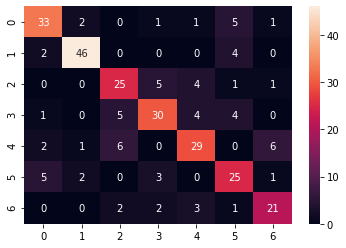

In [44]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True,fmt="d");